Experiment 2:

* Use a Baseline model (Neural Network)
* Language modeling (Glove) with and without data augmentation
* Compare performance of baseline with that of Glove in learning the classes with and without data augmentation.

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

#Importing packages

import pandas as pd 
import numpy as np
import os
import sys

import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

# text pre-processing
import re, string
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer

from tqdm.auto import tqdm
from sklearn.utils import shuffle

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#model building
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, precision_score, recall_score
import sklearn.metrics as metrics
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping


from keras.layers import (LSTM, Embedding, BatchNormalization, Dense, Bidirectional, GlobalMaxPool1D)
                          
from keras.layers.core.flatten import Flatten
from keras.layers.convolutional import MaxPooling1D
from keras.layers.convolutional import Conv1D

from keras.preprocessing import sequence, text

#import regular expressions 
import re

#for word embedding
! pip install gensim #install gensim

import gensim
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec


# for text processing
! pip install spacy

! pip install tokenization
! pip install keras

import tokenization
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing

import spacy 

# install wordcloud
! pip install wordcloud

import warnings
warnings.filterwarnings("ignore") # ignore SettingWithCopyWarning

import nltk
nltk.download('stopwords')

from numpy.random import seed # set random seed
seed(1)

In [ ]:
#load data
df = pd.read_csv('/content/drive/MyDrive/Applied A.I assignment/amazon_alexa.tsv', sep='\t')

In [ ]:
#Check label distribution
df.feedback.value_counts()

1    2893
0     257
Name: feedback, dtype: int64

In [ ]:
df.isna().sum() #dataset is clean - confirmed

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

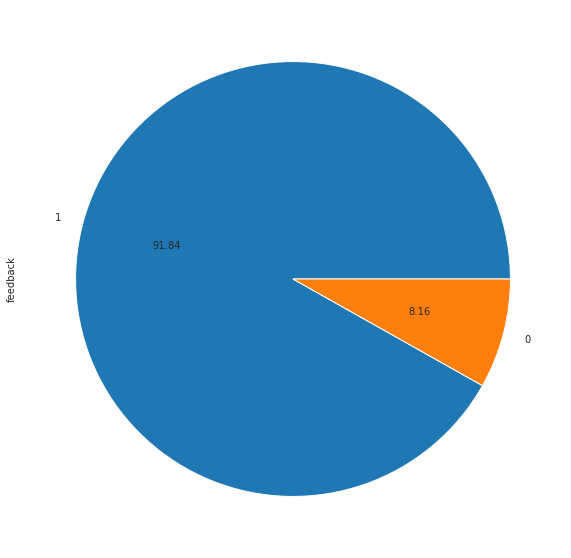

In [ ]:
#visualize target with pie chart

plt.figure(figsize=(10,10))
df.feedback.value_counts().plot.pie(autopct='%.2f');

92% (approx) of feedback are positive feedback.

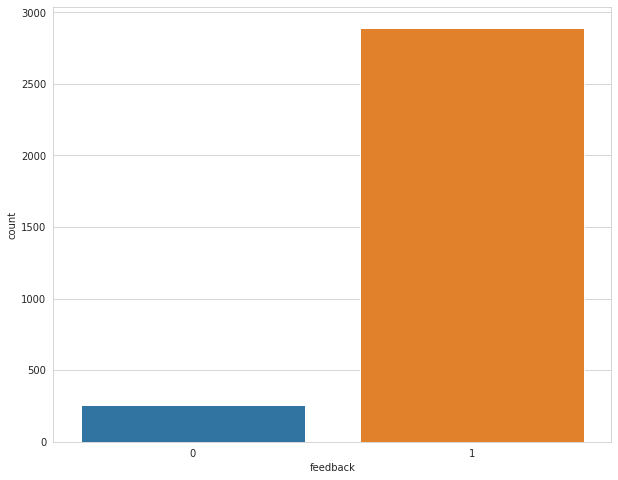

In [ ]:
plt.figure(figsize=(10, 8))
sns.countplot(x= 'feedback', data = df); #plot target

In [ ]:
df.head(3)

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1


**Preprocessing**

In [ ]:
def preprocess(sentence):         #convert to lowercase & remove punctuation
  sentence = sentence.lower()
  sentence = sentence.strip()
  sentence = re.compile('<.*?>').sub('', sentence)
  sentence = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', sentence)
  sentence = re.sub('\s+', ' ', sentence)
  sentence = re.sub(r'\[[0-9]*\']','',sentence)
  sentence = re.sub(r'[^\w\s]', '', str(sentence).lower().strip())
  sentence = re.sub(r'\d', ' ', sentence)
  sentence = re.sub(r'\s+', ' ', sentence)
  return sentence


# remove stopword
def stopword(string):
  a = [i for i in string.split() if i not in stopwords.words('english')]
  return ' '.join(a)


# lemantization
#initialize lemantizer
word_lemmatizer = WordNetLemmatizer()

# map NLTK position tags
def get_wordnet_pos(tag):
  if tag.startswith('J'):
    return wordnet.ADJ
  elif tag.startswith('V'):
    return wordnet.VERB
  elif tag.startswith('N'):
    return wordnet.NOUN
  elif tag.startswith('R'):
    return wordnet.ADV
  else:
    return wordnet.NOUN


#Tokenize sentence
def lemmatizer(string):
  word_pos_tags = nltk.pos_tag(word_tokenize(string)) #get position tags
  a =[word_lemmatizer.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] #map position tag and lemmatize the word/token
  return " ".join(a)


# final pre-processing
def finalpreprocessing(string):
  return lemmatizer(stopword(preprocess(string)))


In [ ]:
#import nltk
import nltk
nltk.download('omw-1.4')

#apply preprocessing
df['cleaned'] = df['verified_reviews'].apply(lambda x: finalpreprocessing(x))
df.cleaned.head(3)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


0                                            love echo
1                                                 love
2    sometimes play game answer question correctly ...
Name: cleaned, dtype: object

In [ ]:
df.cleaned.apply(lambda x: len(str(x).split())).max() #max words

255

In [ ]:
#set positive & negative feedback
target = {0: "Negative", 1: "Positive"}

def encode_target(label):
  return target[label]

df.feedback = df.feedback.apply(lambda x: encode_target(x))

In [ ]:
#create functions for baseline model, metrics and visualization

labels = ['Positive', 'Negative']

#Baseline (LSTM - RNN as baseline)
def baseline():
  # create model
  model = Sequential()
  model.add(Embedding(max_words, embedding_dim, input_length=X.shape[1]))
  model.add(SpatialDropout1D(0.2))
  model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2)) #100 LSTM units
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model


def metrics(pred, y_test):
  #convert test labels from one-hot encoding to single digits 
  #to generate evaluation metrics below
    y_test_arg = np.argmax(y_test, axis=1) #returm max in array 
    pred_arg = np.argmax(model.predict(X_test), axis=1) #returm max in array
    print("F1-score: ", round(f1_score(pred_arg, y_test_arg, average='weighted'),4)) #imbalanced target, weighted average 
    print("Precision: ", round(precision_score(pred_arg, y_test_arg, average='weighted'),4))
    print("Recall: ", round(recall_score(pred_arg, y_test_arg, average='weighted'), 4))
    print("Acuracy: ", round(accuracy_score(pred_arg, y_test_arg), 4))
    print("-" * 60)
    print(classification_report(pred_arg, y_test_arg, target_names = labels))
    print("---" * 20)

import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    #prints and plot the confusion matrix.

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)


#'macro': Calculate metrics for each label, and find their unweighted mean. It does not take label 
#imbalance into account.
#'weighted': Calculate metrics for each label, and find their average weighted by support (the number
# of true instances for each label). It alters 'macro' to account for label imbalance; can result in an
# F-score that is not between precision and recall.
    
def plot(history, acc):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[acc[idx][0]])
        ax[idx].plot(history.history[acc[idx][1]])
        ax[idx].legend([acc[idx][0], acc[idx][1]],fontsize=16)
        ax[idx].set_title(acc[idx][0] + ' and ' + acc[idx][1],fontsize=16)

**Model Building**

Without Data Augmentation

Baseline Model

In [ ]:
#tokenize & split data
max_words = 50000 #max number of words to be used (most frequent)
max_seq = 250 #max word count per review
embedding_dim = 100


tokenizer= Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower =True)
tokenizer.fit_on_texts(df['cleaned'].values)
word_index = tokenizer.word_index

vocab_length = len(tokenizer.word_index) + 1

X = tokenizer.texts_to_sequences(df['cleaned'].values)
X = pad_sequences(X, maxlen = max_seq)

y = pd.get_dummies(df['feedback']).values #encode target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True, random_state=1, stratify = y)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape #check shape

((2520, 250), (2520, 2), (630, 250), (630, 2))

In [ ]:
#instantiate model
model = baseline()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 5,080,602
Trainable params: 5,080,602
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#fit LSTM model (baseline)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

history= model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.1, 
                   callbacks=[earlystop])

Epoch 1/100
36/36 [==============================] - 17s 390ms/step - loss: 0.3795 - accuracy: 0.9021 - val_loss: 0.2346 - val_accuracy: 0.9405
Epoch 2/100
36/36 [==============================] - 13s 369ms/step - loss: 0.2852 - accuracy: 0.9158 - val_loss: 0.2212 - val_accuracy: 0.9405
Epoch 3/100
36/36 [==============================] - 13s 370ms/step - loss: 0.2567 - accuracy: 0.9158 - val_loss: 0.1959 - val_accuracy: 0.9405
Epoch 4/100
36/36 [==============================] - 13s 372ms/step - loss: 0.1710 - accuracy: 0.9453 - val_loss: 0.1790 - val_accuracy: 0.9484
Epoch 5/100
36/36 [==============================] - 13s 371ms/step - loss: 0.0993 - accuracy: 0.9678 - val_loss: 0.1908 - val_accuracy: 0.9484
Epoch 6/100
36/36 [==============================] - 13s 371ms/step - loss: 0.0688 - accuracy: 0.9784 - val_loss: 0.1773 - val_accuracy: 0.9444
Epoch 7/100
36/36 [==============================] - 14s 388ms/step - loss: 0.0468 - accuracy: 0.9859 - val_loss: 0.1989 - val_accuracy:

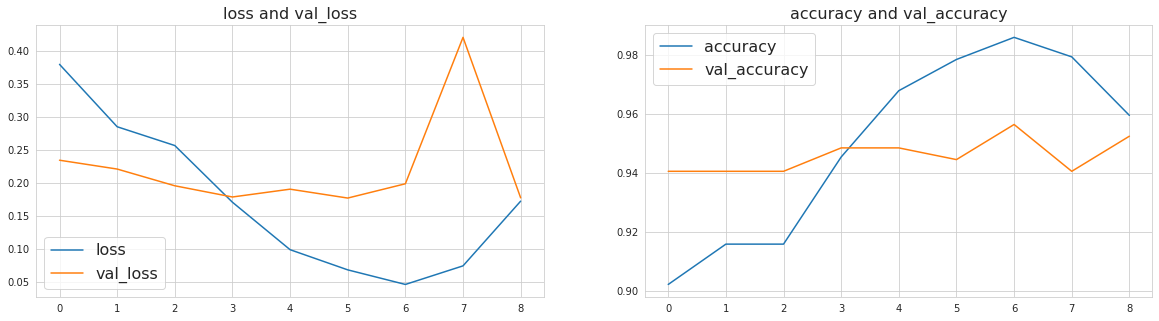

In [ ]:
# generate plot
plot(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [ ]:
#evaluate model
result = model.evaluate(X_test, y_test)
print('Baseline model accuracy: %.2f%%' % (result[1] * 100))

20/20 [==============================] - 1s 39ms/step - loss: 0.2115 - accuracy: 0.9333
Baseline model accuracy: 93.33%


In [ ]:
# print(confusion_matrix(y_test, y_preds))

# #plot confusion matrix
# cnf_matrix = confusion_matrix(test_data.feedback.to_list(), y_pred_1d)
# plt.figure(figsize=(8,8))
# plot_confusion_matrix(cnf_matrix, classes=test_data.feedback.unique(), title="Confusion matrix")
# plt.show()

In [ ]:
#generate metrics


pred = model.predict(X_test)
metrics(pred, y_test)

F1-score:  0.949
Precision:  0.9732
Recall:  0.9333
Acuracy:  0.9333
------------------------------------------------------------
              precision    recall  f1-score   support

    Positive       0.25      0.76      0.38        17
    Negative       0.99      0.94      0.96       613

    accuracy                           0.93       630
   macro avg       0.62      0.85      0.67       630
weighted avg       0.97      0.93      0.95       630

------------------------------------------------------------


Baseline: Simple LSTM with model.

The baseline model performance recorded 93% accuracy with the model leaning towards the majority class (positive class). Balancing the target should be able to improve the scores from the classification report. This can be achieved through data augmentation for text instead of over/undersampling methods.

LSTM with Glove embedding

In [ ]:
#Prepare data

X = df.cleaned
y = df.feedback

size = 0.7 #70% train data size
max_words = 50000
max_seq = 30

train_data, test_data = train_test_split(df, test_size=1-size,
                                         random_state=1) # Splits Dataset

print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 2204
Test Data size 946


In [ ]:
#tokenize data
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.cleaned)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 2754


In [ ]:
#pad sequence
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.cleaned),
                        maxlen = max_seq)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.cleaned),
                       maxlen = max_seq)

print("Train X Shape:",x_train.shape)
print("Test X Shape:",x_test.shape)

Train X Shape: (2204, 30)
Test X Shape: (946, 30)


In [ ]:
labels = train_data.feedback.unique().tolist()

In [ ]:
#encode target & reshape train and test
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(train_data.feedback.to_list())

y_train = encoder.transform(train_data.feedback.to_list())
y_test = encoder.transform(test_data.feedback.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (2204, 1)
y_test shape: (946, 1)


In [ ]:
#doenload and unzip Glove 
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

In [ ]:
glove_emb = 'glove.6B.300d.txt'
emb_dim = 300
learning_rate = 1e-3
batch_size = 64
epochs = 20

In [ ]:
emb_index = {}

f = open(glove_emb)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  emb_index[word] = coefs
f.close()

print('Word vectors count %s' %len(emb_index))

Word vectors count 400000


In [ ]:
emb_matrix = np.zeros((vocab_size, emb_dim))
for word, i in word_index.items():
  emb_vector = emb_index.get(word)
  if emb_vector is not None:
    emb_matrix[i] = emb_vector

In [ ]:
#instantiate glove model

import tensorflow
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

emb_layer = tf.keras.layers.Embedding(vocab_size, emb_dim, weights=[emb_matrix], input_length=max_seq, trainable=False)

input_seq = Input(shape=(max_seq,), dtype='int32')
emb_seq = emb_layer(input_seq)
j = SpatialDropout1D(0.2)(emb_seq)
j = Conv1D(64, 5, activation='relu')(j)
j = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(j)
j = Dense(512, activation='relu')(j)
j = Dropout(0.5)(j)
j = Dense(512, activation='relu')(j)
output = Dense(1, activation='sigmoid')(j)
model_glove = tf.keras.Model(input_seq, output)

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model_glove.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
callbacks = ReduceLROnPlateau(factor=0.1, min_lr = 0.01, monitor = 'val_loss', verbose = 1)

In [ ]:
#fit model
history = model_glove.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), 
                    callbacks=[callbacks])

Epoch 1/20
35/35 [==============================] - 8s 84ms/step - loss: 0.3285 - accuracy: 0.9129 - val_loss: 0.2331 - val_accuracy: 0.9228 - lr: 0.0010
Epoch 2/20
35/35 [==============================] - 2s 68ms/step - loss: 0.2175 - accuracy: 0.9165 - val_loss: 0.1977 - val_accuracy: 0.9228 - lr: 0.0010
Epoch 3/20
35/35 [==============================] - 2s 69ms/step - loss: 0.1720 - accuracy: 0.9265 - val_loss: 0.1814 - val_accuracy: 0.9239 - lr: 0.0010
Epoch 4/20
35/35 [==============================] - 2s 68ms/step - loss: 0.1225 - accuracy: 0.9519 - val_loss: 0.2080 - val_accuracy: 0.9397 - lr: 0.0010
Epoch 5/20
35/35 [==============================] - 2s 69ms/step - loss: 0.0762 - accuracy: 0.9701 - val_loss: 0.2342 - val_accuracy: 0.9281 - lr: 0.0010
Epoch 6/20
35/35 [==============================] - 2s 69ms/step - loss: 0.0594 - accuracy: 0.9800 - val_loss: 0.2656 - val_accuracy: 0.9387 - lr: 0.0010
Epoch 7/20
35/35 [==============================] - 2s 69ms/step - loss: 0.0

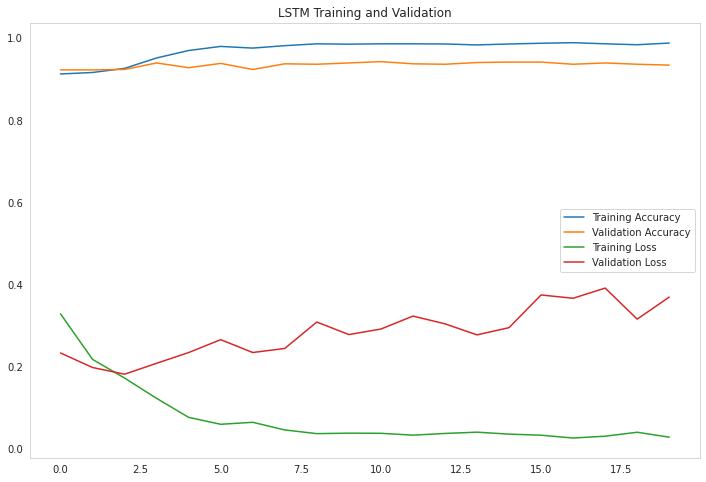

In [ ]:
#visualize

acc_glove = history.history['accuracy']
val_acc_glove = history.history['val_accuracy']

loss_glove = history.history['loss']
val_loss_glove = history.history['val_loss']

epochs_range = range(epochs)


plt.figure(figsize = (12, 8))
plt.plot(epochs_range, acc_glove, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc_glove, label = 'Validation Accuracy')

plt.plot(epochs_range, loss_glove, label = 'Training Loss')
plt.plot(epochs_range, val_loss_glove, label = 'Validation Loss')
plt.legend(loc = 'best')
plt.title('LSTM Training and Validation')
plt.grid(False)

plt.show()

In [ ]:
#set threshold for positive/negative sentiment
def get_sentiment(score): 
    return "Positive" if score>0.5 else "Negative"


scores = model_glove.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [get_sentiment(score) for score in scores]

1/1 [==============================] - 1s 556ms/step


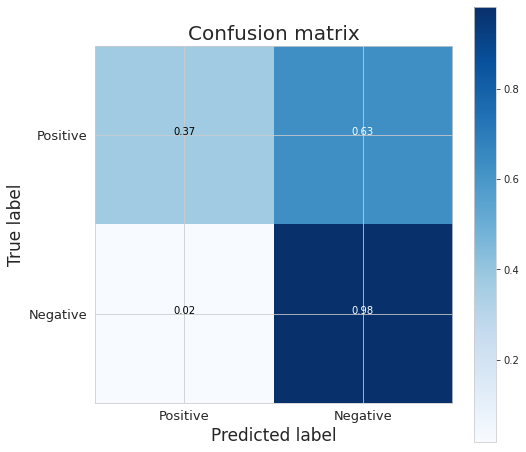

In [ ]:
#plot confusion matrix
cnf_matrix = confusion_matrix(test_data.feedback.to_list(), y_pred_1d)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=test_data.feedback.unique(), title="Confusion matrix")
plt.show()

In [ ]:
print(classification_report(list(test_data.feedback.to_list()), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.63      0.37      0.47        73
    Positive       0.95      0.98      0.97       873

    accuracy                           0.93       946
   macro avg       0.79      0.68      0.72       946
weighted avg       0.92      0.93      0.93       946



**Glove model**

From the confusion matrix, the model is leaning towards the positive feedback since the data is imbalanced. This can be deduced from the lower scores recorded by Precision, Recall and F1-score when compared to the positive class.

The confusion matric on the other hand is able to correctly classify TN than TP.

A repeat of the experiment would be conducted with data augmentation for the classes to investigate the performance in classifying the classes.

**Baseline Vs. Glove Model Performance**

#### Compare the performance of the simple LSTM baseline with that of the Glove model stating the difference in the model setup vis-a-vis hyperparameters used, number of layers, F1, Precision and Recall Scores and the confusion matrix.

**Model Building**

With Data Augmentation

In [ ]:
df.cleaned.iloc[5]

'receive echo gift need another bluetooth something play music easily accessible find smart speaker cant wait see else'

In [ ]:
#install required libraries
! pip install transformers
! pip install nlpaug

In [ ]:
import nlpaug.augmenter.word.context_word_embs as aug

In [ ]:
#check augmenter
check_sample = df.cleaned.iloc[5]
check_sample

'receive echo gift need another bluetooth something play music easily accessible find smart speaker cant wait see else'

In [ ]:
augmenter = aug.ContextualWordEmbsAug(model_path='bert-base-uncased', action='insert') #instantiate augmenter

In [ ]:
augmented_text_sample = augmenter.augment(check_sample)
augmented_text_sample #check augmenter on sample text

['to receive echo gift if need another call bluetooth or something play music easily accessible and find smart speaker system cant wait see else']

In [ ]:
#check 6 different output for sample augmented text
for i in range(6):
  print(augmenter.augment(check_sample))

['receive echo gift need be another bluetooth something play any music are easily accessible find you smart speaker cant keep wait just see else']
['receive one echo phone gift need another call bluetooth something play music user easily accessible find smart speaker cant open wait see where else']
['a receive echo gift need another bluetooth something play music again easily help accessible find smart speaker i cant miss wait see what else']
['receive echo gift need another bluetooth download something play all music is easily accessible online find smart music speaker box cant wait see else']
['receive echo gift we need another bluetooth something play our music easily accessible find smart portable speaker but cant miss wait see anyone else']
['we receive echo free gift no need another voice bluetooth something play music please easily make accessible find smart speaker cant wait see else']


In [ ]:
df.feedback.value_counts() #check target to augment before mapping

Positive    2893
Negative     257
Name: feedback, dtype: int64

In [ ]:
#convert target to int 

target_map = {'Positive': 0,
              'Negative': 1}

df['feedback'] = df['feedback'].map(target_map)

In [ ]:
df.feedback.value_counts() #check target to augment after mapping

0    2893
1     257
Name: feedback, dtype: int64

In [ ]:
#function to augment df
def augment_df(df, augmenter, repetitions=1, samples=2636): #match minority class to majority class
  augmented_texts = [] #store texts
  #select minority class
  neg_class = df[df['feedback'] == 1].reset_index(drop=True) #exclude index column
  for i in tqdm(np.random.randint(0, len(neg_class), samples)):
    #generate augmented text samples
    for _ in range(repetitions):
      augmented_text = augmenter.augment(neg_class['cleaned'].iloc[i])
      augmented_texts.append(augmented_text)

  data = {'feedback': 1,
          'cleaned': augmented_texts}
  df_aug = pd.DataFrame(data)  
  df = shuffle(df.append(df_aug).reset_index(drop=True)) #shuffle and append df_aug
  return df

In [ ]:
df_aug = augment_df(df, augmenter, samples=2636) #experiment with matched target class size

  0%|          | 0/2636 [00:00<?, ?it/s]

In [ ]:
df_aug.feedback.value_counts() #check aug

print('\n Original Data Shape: ', df.shape)
print('\n Augmented Data Shape: ', df_aug.shape)


 Original Data Shape:  (3150, 6)

 Augmented Data Shape:  (5786, 6)


In [ ]:
#tokenize X_train and convert to array

max_words = 50000 #max number of words to be used (most frequent)
max_seq = 250 #max word count per review
embedding_dim = 100


tokenizer= Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower =False)
tokenizer.fit_on_texts(df_aug['cleaned'].values)

vocab_length = len(tokenizer.word_index) + 1

word_index = tokenizer.word_index



X = tokenizer.texts_to_sequences(df_aug['cleaned'].values)
X = pad_sequences(X, maxlen = max_seq)

y = pd.get_dummies(df_aug['feedback']).values #encode target

In [ ]:
#split data to prevent data leak of augmented samples in test set
X_train, _, y_train, _ = train_test_split(X, y, test_size = 0.1)
_, X_test, _, y_test = train_test_split(df['cleaned'], df['feedback'].values, test_size = 0.5)

x_train = np.asarray(x_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)

"""
Note: train on augmented dataset and test on original dataset for baseline and glove.
"""

**Baseline Model (Augmented)**

In [ ]:
#instantiate model

model_aug = Sequential()
model_aug.add(Embedding(max_words, embedding_dim, input_length=max_seq))
model_aug.add(SpatialDropout1D(0.2))
model_aug.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2)) #100 LSTM units
model_aug.add(Dense(2, activation='softmax'))
model_aug.add(Flatten())
model_aug.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  
model_aug.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d_6 (Spatia  (None, 250, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_6 (LSTM)               (None, 100)               80400     
                                                                 
 dense_8 (Dense)             (None, 2)                 202       
                                                                 
 flatten (Flatten)           (None, 2)                 0         
                                                                 
Total params: 5,080,602
Trainable params: 5,080,602
Non-trainable params: 0
____________________________________________

In [ ]:
#fit LSTM model (baseline)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

history_base_aug= model_aug.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.1, 
                   callbacks=[earlystop])

Epoch 1/100
74/74 [==============================] - 32s 391ms/step - loss: 0.4336 - accuracy: 0.8111 - val_loss: 0.2812 - val_accuracy: 0.9309
Epoch 2/100
74/74 [==============================] - 29s 390ms/step - loss: 0.2201 - accuracy: 0.9306 - val_loss: 0.2244 - val_accuracy: 0.9309
Epoch 3/100
74/74 [==============================] - 29s 387ms/step - loss: 0.1503 - accuracy: 0.9524 - val_loss: 0.2016 - val_accuracy: 0.9463
Epoch 4/100
74/74 [==============================] - 29s 386ms/step - loss: 0.1047 - accuracy: 0.9688 - val_loss: 0.1965 - val_accuracy: 0.9559
Epoch 5/100
74/74 [==============================] - 29s 386ms/step - loss: 0.0740 - accuracy: 0.9774 - val_loss: 0.2293 - val_accuracy: 0.9520
Epoch 6/100
74/74 [==============================] - 29s 388ms/step - loss: 0.0537 - accuracy: 0.9825 - val_loss: 0.2177 - val_accuracy: 0.9520
Epoch 7/100
74/74 [==============================] - 29s 386ms/step - loss: 0.0456 - accuracy: 0.9846 - val_loss: 0.2260 - val_accuracy:

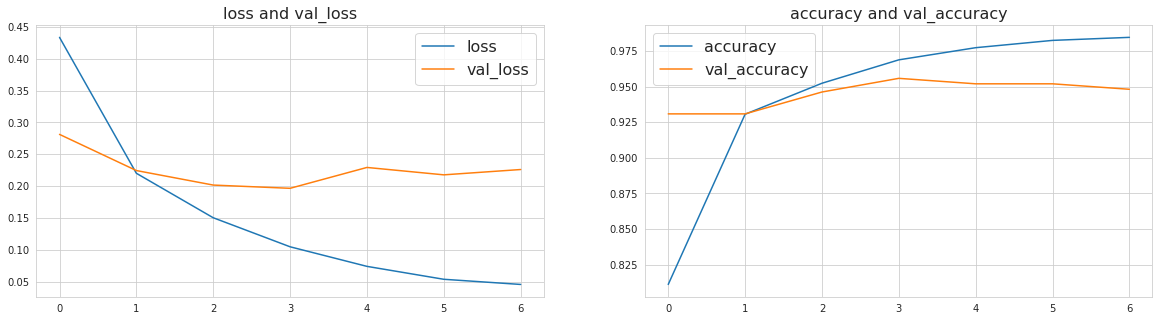

In [ ]:
# generate plot
plot(history_base_aug, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [ ]:
#evaluate model

result = model_aug.evaluate(X_test, y_test)
print('Baseline model accuracy (Augmented): %.2f%%' % (result[1] * 100))

In [ ]:
#generate metrics


pred_aug = model_aug.predict(X_test) 
metrics(pred_aug, y_test) 

**LSTM with Glove (Augmented)**

In [ ]:
#Prepare data

X = df_aug.cleaned
y = df_aug.feedback

size = 0.7 #70% train data size
max_words = 50000
max_seq = 30

train_data_aug, test_data_aug = train_test_split(df_aug, test_size=1-size,
                                         random_state=1) # Splits Dataset

print("Train Data size:", len(train_data_aug))
print("Test Data size", len(test_data_aug))


Train Data size: 4050
Test Data size 1736


In [ ]:

#tokenize data
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data_aug.cleaned)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 4484


In [ ]:
#pad sequence
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data_aug.cleaned),
                        maxlen = max_seq)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data_aug.cleaned),
                       maxlen = max_seq)

print("Train X Shape:",x_train.shape)
print("Test X Shape:",x_test.shape)

Train X Shape: (4050, 30)
Test X Shape: (1736, 30)


In [ ]:
labels = train_data_aug.feedback.unique().tolist()

In [ ]:
#encode target & reshape train and test
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(train_data_aug.feedback.to_list())

y_train = encoder.transform(train_data_aug.feedback.to_list())
y_test = encoder.transform(test_data_aug.feedback.to_list())

#reshape
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (4050, 1)
y_test shape: (1736, 1)


In [ ]:
glove_emb = 'glove.6B.300d.txt'
emb_dim = 300
learning_rate = 1e-3
batch_size = 64
epochs = 20

In [ ]:
emb_index = {}

f = open(glove_emb)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  emb_index[word] = coefs
f.close()

print('Word vectors count %s' %len(emb_index))

Word vectors count 400000


In [ ]:
emb_matrix = np.zeros((vocab_size, emb_dim))
for word, i in word_index.items():
  emb_vector = emb_index.get(word)
  if emb_vector is not None:
    emb_matrix[i] = emb_vector

In [ ]:
#instantiate glove model

import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

emb_layer = tf.keras.layers.Embedding(vocab_size, emb_dim, weights=[emb_matrix], input_length=max_seq, trainable=False)

input_seq = Input(shape=(max_seq,), dtype='int32')
emb_seq = emb_layer(input_seq)
layer = SpatialDropout1D(0.2)(emb_seq)
layer = Conv1D(64, 5, activation='relu')(layer)
layer = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(layer)
layer = Dense(512, activation='relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(512, activation='relu')(layer)
output = Dense(1, activation='sigmoid')(layer)
model_glove_aug = tf.keras.Model(input_seq, output)

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model_glove_aug.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
callbacks = ReduceLROnPlateau(factor=0.1, min_lr = 0.01, monitor = 'val_loss', verbose = 1)

In [ ]:
#fit model
history_glv_aug = model_glove_aug.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), 
                    callbacks=[callbacks])

Epoch 1/20
64/64 [==============================] - 11s 84ms/step - loss: 0.4360 - accuracy: 0.8881 - val_loss: 0.2244 - val_accuracy: 0.9303 - lr: 0.0010
Epoch 2/20
64/64 [==============================] - 5s 76ms/step - loss: 0.1679 - accuracy: 0.9469 - val_loss: 0.1629 - val_accuracy: 0.9510 - lr: 0.0010
Epoch 3/20
64/64 [==============================] - 5s 75ms/step - loss: 0.1297 - accuracy: 0.9620 - val_loss: 0.1599 - val_accuracy: 0.9510 - lr: 0.0010
Epoch 4/20
64/64 [==============================] - 5s 77ms/step - loss: 0.1035 - accuracy: 0.9714 - val_loss: 0.1775 - val_accuracy: 0.9539 - lr: 0.0010
Epoch 5/20
64/64 [==============================] - 5s 75ms/step - loss: 0.0833 - accuracy: 0.9802 - val_loss: 0.2096 - val_accuracy: 0.9510 - lr: 0.0010
Epoch 6/20
64/64 [==============================] - 5s 76ms/step - loss: 0.0843 - accuracy: 0.9775 - val_loss: 0.1975 - val_accuracy: 0.9528 - lr: 0.0010
Epoch 7/20
64/64 [==============================] - 5s 76ms/step - loss: 0.

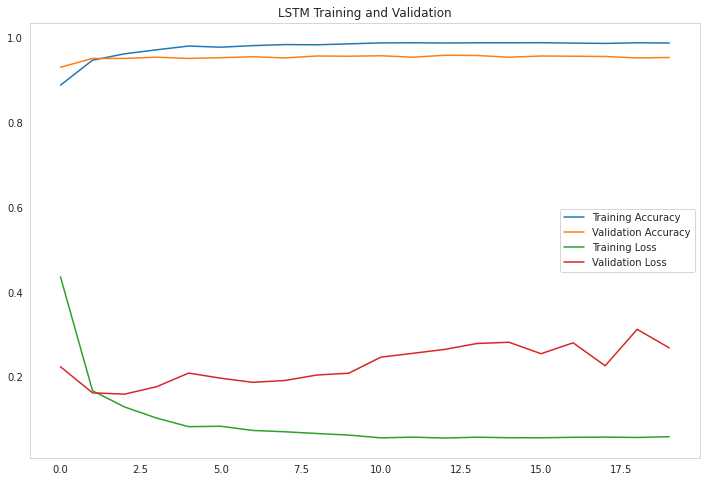

In [ ]:
#visualize

acc_glove = history_glv_aug.history['accuracy']
val_acc_glove = history_glv_aug.history['val_accuracy']

loss_glove = history_glv_aug.history['loss']
val_loss_glove = history_glv_aug.history['val_loss']

epochs_range = range(epochs)


plt.figure(figsize = (12, 8))
plt.plot(epochs_range, acc_glove, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc_glove, label = 'Validation Accuracy')

plt.plot(epochs_range, loss_glove, label = 'Training Loss')
plt.plot(epochs_range, val_loss_glove, label = 'Validation Loss')
plt.legend(loc = 'best')
plt.title('LSTM Training and Validation')
plt.grid(False)

plt.show()

In [ ]:
#set threshold for positive/negative sentiment
def get_sentiment(score): 
    return "Positive" if score>0.5 else "Negative"


scores = model_glove.predict(x_test, verbose=1, batch_size=10000) 
y_pred_aug = [get_sentiment(score) for score in scores]

In [ ]:
#plot confusion matrix
cnf_matrix = confusion_matrix(test_data.feedback.to_list(), y_pred_aug)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=test_data.feedback.unique(), title="Confusion matrix")
plt.show();

In [ ]:
print(classification_report(list(test_data.feedback.to_list()), y_pred_aug))